# Simulación en MuJoCo (GPU).
Requiere cambio de entorno a GPU. Dado que el uso de GPU se limita por tiempo, no lo active hasta que sea necesario para visualizar.

Revisar <https://docs.hello-robot.com/0.3/stretch-mujoco/docs/getting_started/> para ver uso solo con CPU en colab (más lento)

### Librerías necesarias para la simulación en MuJoCo.


In [1]:
# Other imports and helper functions
from IPython.display import clear_output
from typing import Callable, Optional, Union, List
# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media

''' AGREGA TUS LIBRERIAS '''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
import numpy as np

#limpia el mucho texto
clear_output()

In [2]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

clear_output()

In [3]:
#Clonacion del repositorio para los modelos
print('Getting MuJoCo model XML description from GitHub:')
!git clone https://github.com/uwulises/ME3250_tarea_computacional

Getting MuJoCo model XML description from GitHub:
fatal: destination path 'ME3250_tarea_computacional' already exists and is not an empty directory.


## Modelo simulado: SCARA

### Reemplaza los arreglos de joint por tu solución de Newton-Raphson
La pata cuenta con 3 joints, a la cuál se le entrega n arreglos de largo 3. Ojo que el largo de los arreglos debe ser el mismo!

` data_NR := array list((n, 3)) `

In [19]:
#estos valores debes reemplazar con los que encuentra tu metodo NR
hombro_joint = np.linspace(0,3.14,100)
codo_joint = np.linspace(-2.96,2.96,100)
z_joint = np.linspace(0,0.2,100)

In [20]:
data_NR_scara = np.array([hombro_joint,codo_joint,z_joint]).T

### Animación del modelo SCARA

In [21]:
%cd
%cd /content/ME3250_tarea_computacional/mujoco/model/scara
with open('scene.xml', 'r') as f:
  xml = f.read()
model_scara = mujoco.MjModel.from_xml_string(xml)
data_scara = mujoco.MjData(model_scara)
renderer = mujoco.Renderer(model_scara,600,800)

/root
/content/ME3250_tarea_computacional/mujoco/model/scara


In [22]:
DURATION  = 1   # aprox seconds
FRAMERATE = 60  # Hz
camera = mujoco.MjvCamera()
cam1= mujoco.mjv_defaultFreeCamera(model_scara, camera)
camera.distance = 1.3
camera.azimuth = -90
camera.elevation = 0
camera.orthographic=1

mujoco.mj_resetDataKeyframe(model_scara, data_scara, 1)

frames = []
body_positions = [] # List to store end-effector positions

while data_scara.time < DURATION:
  for i in range(len(data_NR_scara)):
    # Set control vector.
    data_scara.ctrl = data_NR_scara[i]
    # Step the simulation.
    mujoco.mj_step(model_scara, data_scara,nstep=10)
    # Append end-effector position to the list
    body_positions.append(data_scara.xpos.copy())
    # Render and save frames.
    if len(frames) < data_scara.time * FRAMERATE:

      camera.lookat = np.array([-0.05, 0.0, 0.3])
      renderer.update_scene(data_scara, camera)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

### Grafiquemos las posiciones XYZ del efector

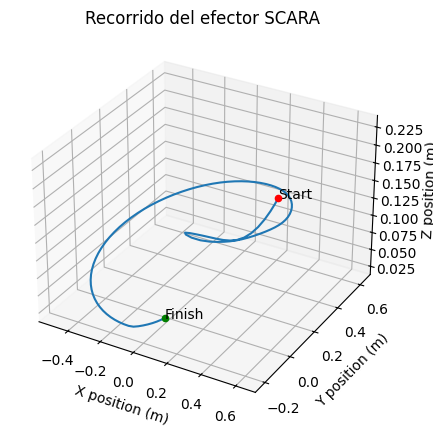

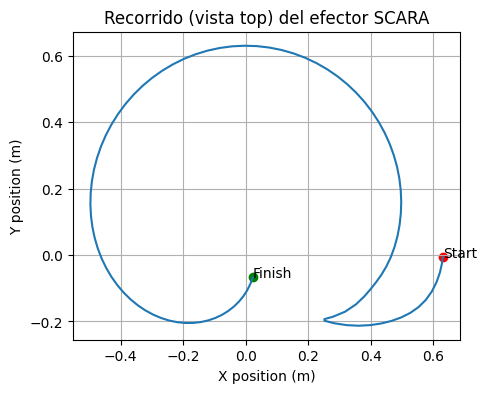

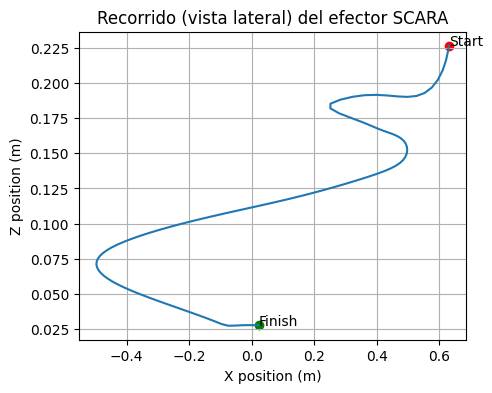

In [23]:
end_effector_positions = np.array(body_positions)
# time_steps, number_of_bodies, xyz_coordinates
num_time_steps, num_bodies, num_coordinates = end_effector_positions.shape

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(end_effector_positions[:, 4, 0], end_effector_positions[:, 4, 1], end_effector_positions[:, 4, 2])
ax.scatter(end_effector_positions[0, 4, 0], end_effector_positions[0, 4, 1], end_effector_positions[0, 4, 2], color='red')
ax.scatter(end_effector_positions[-1, 4, 0], end_effector_positions[-1, 4, 1], end_effector_positions[-1, 4, 2], color='green')
ax.text(end_effector_positions[0, 4, 0], end_effector_positions[0, 4, 1], end_effector_positions[0, 4, 2], 'Start')
ax.text(end_effector_positions[-1, 4, 0], end_effector_positions[-1, 4, 1], end_effector_positions[-1, 4, 2], 'Finish')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.set_title(f'Recorrido del efector SCARA')
ax.grid(True)

#vista top XY
fig2 = plt.figure(figsize=(5, 4))
plt.plot(end_effector_positions[:, 4, 0], end_effector_positions[:, 4, 1])
plt.scatter(end_effector_positions[0, 4, 0], end_effector_positions[0, 4, 1], color='red')
plt.scatter(end_effector_positions[-1, 4, 0], end_effector_positions[-1, 4, 1], color='green')
plt.text(end_effector_positions[0, 4, 0], end_effector_positions[0, 4, 1], 'Start')
plt.text(end_effector_positions[-1, 4, 0], end_effector_positions[-1, 4, 1], 'Finish')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.grid(True)
plt.title(f'Recorrido (vista top) del efector SCARA')

#vista lateral XZ
fig3 = plt.figure(figsize=(5,4))
plt.plot(end_effector_positions[:, 4, 0], end_effector_positions[:, 4, 2])
plt.scatter(end_effector_positions[0, 4, 0], end_effector_positions[0, 4, 2], color='red')
plt.scatter(end_effector_positions[-1, 4, 0], end_effector_positions[-1, 4, 2], color='green')
plt.text(end_effector_positions[0, 4, 0], end_effector_positions[0, 4, 2], 'Start')
plt.text(end_effector_positions[-1, 4, 0], end_effector_positions[-1, 4, 2], 'Finish')
plt.xlabel('X position (m)')
plt.ylabel('Z position (m)')
plt.grid(True)
plt.title(f'Recorrido (vista lateral) del efector SCARA')

plt.show()

